In [29]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import sklearn as sk
import sys
import pickle

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from elegir_modelo import metodo
import procesos
import lq

In [3]:
covid = gpd.read_file('datos/covid_periodos.shp', index = True)
covid = covid.set_index(['link','mes']).sort_index(level = 0)
covid = covid.loc[pd.IndexSlice[:,'2020-03':],:]
covid = covid.to_crs('POSGAR94')

# Separamos los campos geometricos del dataframe
geo = covid.loc[pd.IndexSlice[:,'2021-01'],'geometry']
geo = geo.reset_index(level = 'mes', drop = True)
centroides = covid.loc[pd.IndexSlice[:,'2021-01'],'geometry'].to_crs('POSGAR94').centroid
centroides = centroides.reset_index(level = 'mes', drop = True)
print("las cordenadas CRS son: "+str(geo.crs))
codiprov = covid.loc[pd.IndexSlice[:,'2021-01'],['codpcia','departamen','provincia']]


columnas = ['clasificac', 'fallecido']

# Variables acumuladas a partir del mes que todas tienen al menos 1 

covid_acum = covid[columnas].groupby(covid.index.get_level_values(0)).cumsum()
# buscamos el mes en que todos los dptos tienen al menos 1 contagio
mes = 0
valor = True
while valor == True:
    Mes = covid.index.get_level_values(1).unique()[mes]
    valor = np.any(covid_acum.loc[pd.IndexSlice[:,Mes],'clasificac'] == 0)
    mes +=1
print("El mes desde el cuál todos los dptos tienen al menos 1 contagiado es: "+str(Mes))
covid_acum['personas'] = covid.personas

covid2 = covid_acum.loc[pd.IndexSlice[:,Mes:],:]

las cordenadas CRS son: POSGAR94
El mes desde el cuál todos los dptos tienen al menos 1 contagiado es: 2021-01


C:\Users\paban\anaconda3\envs\covid\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':


In [4]:
from lq import *
from sklearn.metrics import silhouette_score,  calinski_harabasz_score

lqcovid = lq_peri(covid_acum[['fallecido','personas']])
lqcovid2 = lq_peri(covid_acum[['clasificac','personas']])
lqcovid3 = lq_peri(covid2[['fallecido','clasificac']])

def df_datos(df):
    mes = ['2020-03']
    df = df.copy().set_index('link')
    col = list(df.columns)
    ind = col.index('personas')
    return df[col[:ind]].copy()

def siluetas(X, model):
    X_ = df_datos(X)
    return silhouette_score(X_, X[model])
def calinski(X, model):
    X_ = df_datos(X)
    return sk.metrics.calinski_harabasz_score(X_, X[model])
def inv_davies_bouldin(X,model):
    X_ = df_datos(X)
    return (sk.metrics.davies_bouldin_score(X_,X[model]))**-1
def indice_lq(X, model):
    X_ = df_datos(X)
    grupos = X[model].values
    ind = lqcovid.calcular_indice_debil(grupos)
    return 1-ind

In [22]:
archivo = 'df_R/fallec.shp'
df =gpd.read_file('df_R/fallec.shp')
#df = df.set_index(df.link.astype(int))
#df = df.drop('link', axis = 1)
[[siluetas(df,'sk'),siluetas(df,'redcap'),siluetas(df,'schc')],
[indice_lq(df,'sk'),indice_lq(df,'redcap'),indice_lq(df,'schc')]]

[[0.18425467546513144, 0.08774696567418787, -0.01754359092252447],
 [0.5941176470588235, 0.5117647058823529, -0.11764705882352944]]

In [116]:
archivos = ['fallec', 'fallec_pca', 'positiv', 'positiv_pca','fall_pos','fall_pos_pca']
result = {}
for a in archivos:
    arch = 'df_R/'+a+'.shp'
    df = gpd.read_file(arch)
    r = [[siluetas(df,'sk'),siluetas(df,'redcap'),siluetas(df,'schc')],
    [calinski(df,'sk'),calinski(df,'redcap'),calinski(df,'schc')],
    [inv_davies_bouldin(df,'sk'),inv_davies_bouldin(df,'redcap'),inv_davies_bouldin(df,'schc')], 
    [indice_lq(df,'sk'),indice_lq(df,'redcap'),indice_lq(df,'schc')]]
    r = pd.DataFrame(r, columns = ('sk','redcap','schc'), index = ['sil','cal','dav','lqg'])
    result[a] = r
    

In [117]:
for k in result.keys():
    print(k),
    print(result[k])

fallec
            sk     redcap      schc
sil  -0.295056  -0.266123 -0.612484
cal  16.187580  15.676727  1.319989
dav   0.367650   0.345572  0.872176
lqg   0.250505   0.298396  0.119073
fallec_pca
            sk     redcap      schc
sil  -0.318379  -0.357582 -0.520127
cal  76.097682  68.223360  1.133577
dav   0.160671   0.087132  0.459595
lqg   0.306120   0.310636  0.027332
positiv
             sk      redcap      schc
sil    0.248795    0.281476 -0.144715
cal  108.527928  123.649623  1.545357
dav    0.725367    0.759896  0.851602
lqg    0.535294    0.529412 -0.041176
positiv_pca
             sk      redcap      schc
sil    0.204395    0.177647 -0.212282
cal  107.584460  106.590642  0.708889
dav    0.600864    0.533063  0.732134
lqg    0.541176    0.641176 -0.129412
fall_pos
            sk      redcap      schc
sil   0.187754    0.191917 -0.005955
cal  88.304911  117.160714  1.558539
dav   0.123380    0.259079  1.236087
lqg   0.470588    0.600000  0.052941
fall_pos_pca
            sk 

In [8]:
import os
cont = os.listdir('Resultados')
objetos = {}
for fichero in cont:
    if fichero.endswith('.pickle'):
        with open('Resultados/'+fichero, 'rb') as f:
            met = pickle.load(f)
        nomb = fichero[:fichero.find('.')]
        objetos[nomb] = met

In [9]:
l = []
for i in objetos.keys():
    df = objetos[i].best_metrics_.copy()
    model = objetos[i].best_model_
    df['grupos'] = model['modelo'].iloc[0].n_clusters
    df['modelo'] = model['modelo'].iloc[0]
    df['bd'] = i
    l.append(df)    

res = pd.concat(l)

In [10]:
res.sort_values('lqg') 

,sil,cal,dav,lqg,grupos,modelo,bd
190,0.158057,65.009945,0.339866,0.188235,5,"AgglomerativeClustering(affinity='cosine',\n ...",aglo_geofall
0,0.109430,27.234925,0.164799,0.328571,5,"KShape(n_clusters=5, tol=0.0001)",kshapefallpos
57,0.143465,73.918755,0.216707,0.411765,5,"AgglomerativeClustering(affinity='l2',\n ...",aglo_geo2fall
0,-0.079273,40.058301,0.324619,0.458824,5,"KShape(n_clusters=5, tol=0.0001)",kshapefall
76,0.303497,167.254474,0.814147,0.528571,5,"AgglomerativeClustering(affinity='l2', linkage...",aglofallpos
171,0.008189,104.909875,0.391680,0.594118,5,"AgglomerativeClustering(affinity='cosine',\n ...",aglo_geo2posit
4,0.412941,527.303979,0.911772,0.600000,5,"TimeSeriesKMeans(init='random', metric='dtw', ...",tskmfallpos
1,0.506131,637.309813,1.535049,0.609804,6,KMeans(n_clusters=6),kmeansfall
171,-0.143308,92.096209,0.219349,0.614286,5,"AgglomerativeClustering(affinity='cosine',\n ...",aglo_geofallpos
76,0.479336,483.695381,1.558747,0.623529,5,"AgglomerativeClustering(affinity='l2', linkage...",aglofall


In [19]:
result['fallec'].T.to_excel('Resultados/indices.xlsx', sheet_name = 'espacial')
res.to_excel('Resultados/indices2.xlsx', sheet_name = 'otros algorit')

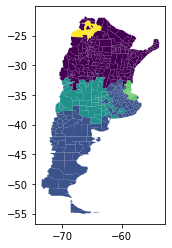

In [28]:
fig, ax = plt.subplots()
df.plot('sk', figsize = (10,8), ax = ax)
fig.savefig('Resultados/Imagenes/skatter.png')

In [49]:
covid_pcia = covid_acum.groupby([covid.codpcia, covid_acum.index.get_level_values(1)]).sum()

## Gráfico de evolución del covid por mes

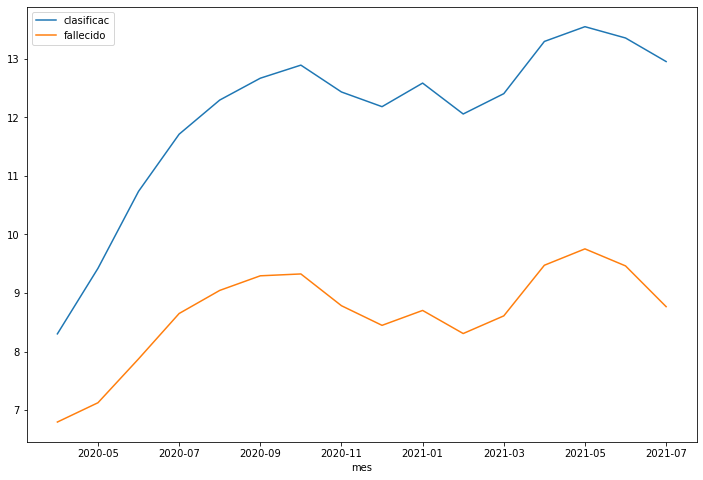

In [66]:
fig, ax = plt.subplots()
np.log(covid_pcia.groupby(level=1).sum()[['clasificac','fallecido']].diff(1)).plot(figsize = (12,8), ax = ax)
fig.savefig('Resultados/Imagenes/covid_total.png')


## Mapas de coropletes meses de picos

In [73]:
covid_acum_geo = covid_acum.copy()
covid_acum_geo['geometry'] = covid['geometry'] 
covid_acum_geo = gpd.GeoDataFrame(covid_acum_geo, crs = 'POSGAR94')

In [77]:
covid_acum_geo['lq'] = lq(covid_acum_geo, 'fallecido','personas')[2]

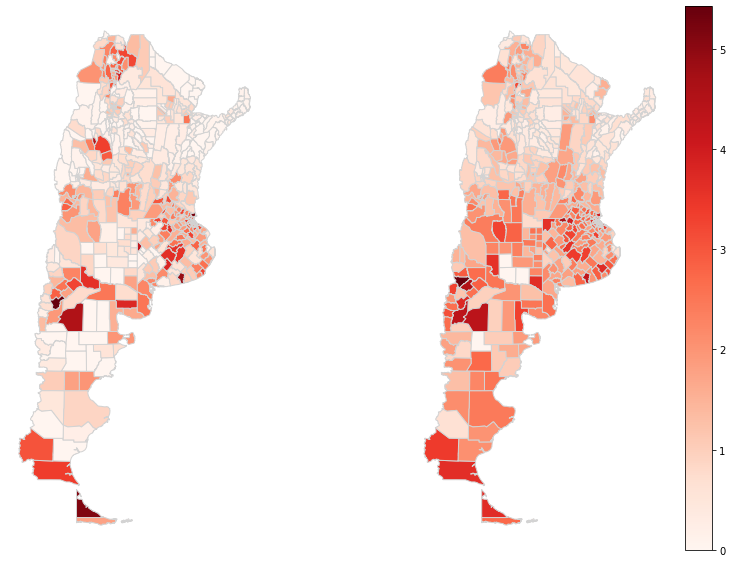

In [102]:
plt.rcParams["figure.figsize"] = (14,10)
fig, ax = plt.subplots(1,2)
covid_acum_geo.loc[pd.IndexSlice[:,'2020-10'],:].plot('lq', ax = ax[0], cmap = 'Reds', edgecolor = 'lightgray')
covid_acum_geo.loc[pd.IndexSlice[:,'2021-05'],:].plot('lq', ax = ax[1], legend = True, cmap = 'Reds', edgecolor = 'lightgray')
ax[0].set_axis_off()
ax[1].set_axis_off()
fig.savefig('Resultados/Imagenes/lq_meses_pico.png')